<a href="https://colab.research.google.com/github/calibretaliation/DeepLearning20211/blob/main/Test_Shopee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/calibretaliation/DeepLearning20211

fatal: destination path 'DeepLearning20211' already exists and is not an empty directory.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! pip install albumentations==0.4.6
! pip install sklearn

In [4]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [5]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
import torchvision.models as models
import torch.nn as nn
from torch.autograd import Variable
from torchsummary import summary
import torch.nn.functional as F

import albumentations as A
import albumentations.pytorch
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [6]:
train_df = pd.read_csv('./DeepLearning20211/data/train.csv')
test_df = pd.read_csv('./DeepLearning20211/data/test.csv')
train_img_path = './DeepLearning20211/data/train_images'
test_img_path = './DeepLearning20211/data/test_images'

In [7]:
def my_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
my_seed(33)

In [8]:
train_df['file_path'] = train_df.image.apply(lambda x: os.path.join(train_img_path, x))
train_df.head(5)

,posting_id,image,image_phash,title,label_group,file_path
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,./DeepLearning20211/data/train_images/0000a688...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,./DeepLearning20211/data/train_images/00039780...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,./DeepLearning20211/data/train_images/000a190f...
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,./DeepLearning20211/data/train_images/00117e4f...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,./DeepLearning20211/data/train_images/00136d1c...


In [9]:
# Drop duplicate by p-hash
# train_df = train_df.drop_duplicates(subset=['image_phash'],keep = 'first')
train_df = train_df.reset_index()
train_df.image_phash.value_counts()

fad28daa2ad05595    26
d0c0ea37bd9acce0    20
be12e12f9ec1e198    17
e992966d4ba49761    16
f6d98134b904b56b    16
                    ..
ec9aa383a3196e4b     1
8bf2f10dfc21970c     1
bef1ccfc818043e3     1
bc93d34ecd31306c     1
c5b4c80f3ff0264b     1
Name: image_phash, Length: 28735, dtype: int64

In [10]:
#check if label group preserved
train_df.label_group.value_counts()

994676122     51
159351600     51
562358068     51
3113678103    51
1163569239    51
              ..
3996065489     2
517023446      2
2101581536     2
3460538113     2
3927456083     2
Name: label_group, Length: 11014, dtype: int64

In [11]:
le = LabelEncoder()
train_df.label_group = le.fit_transform(train_df.label_group)
train_df['label_group'].value_counts()

2606     51
8037     51
1445     51
412      51
2994     51
         ..
10795     2
4652      2
6701      2
558       2
8172      2
Name: label_group, Length: 11014, dtype: int64

In [12]:
X = train_df.drop(columns = 'label_group')
Y = train_df['label_group']
Y.head()

0      666
1     7572
2     6172
3    10509
4     9425
Name: label_group, dtype: int64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=1, stratify=Y)

In [14]:
class ShopeeDataset(Dataset):

    def __init__(self, dataframe, dir_path, mode, transforms):
        self.dataframe = dataframe
        self.dir_path = dir_path
        self.augmentations = transforms
        self.mode = mode
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_info = self.dataframe.iloc[index]
        img = cv2.imread(img_info.file_path)
        label = torch.tensor([img_info['label_group']])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            augmented = self.augmentations(image=img)
            img = augmented['image']   

        if self.mode == 'test':
            return torch.tensor(img).float()
        else:
            return torch.tensor(img).float(), torch.tensor(img_info.label_group).int()
      

transforms_train = albumentations.Compose([ 
    albumentations.augmentations.transforms.Flip(),
    albumentations.augmentations.transforms.Cutout(),
    albumentations.augmentations.transforms.ShiftScaleRotate(rotate_limit=180, p=0.5, interpolation = cv2.INTER_LANCZOS4),
    albumentations.augmentations.transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    albumentations.augmentations.transforms.Resize(224, 224), 
    ToTensorV2() 
    ])
transforms_valid = albumentations.Compose([
    albumentations.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    albumentations.Resize(224, 224),
    ToTensorV2()
])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


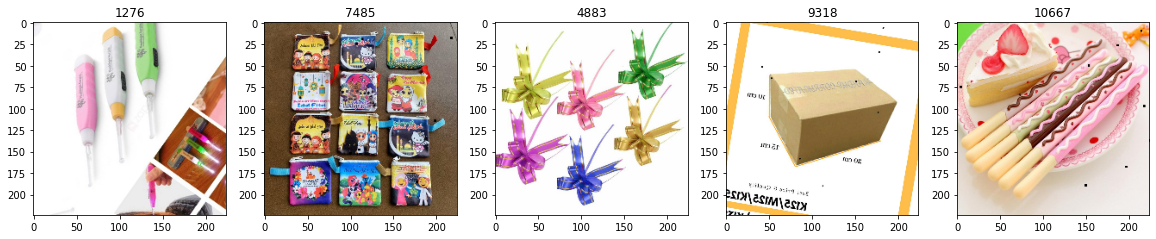

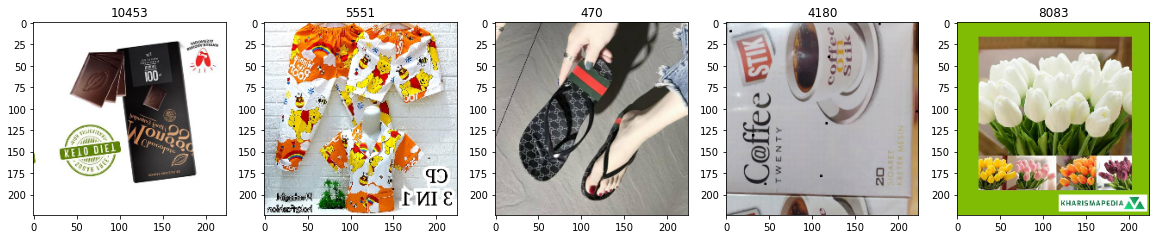

In [15]:
train_split = pd.concat([X_train, y_train], axis = 1)
valid_split = pd.concat([X_test, y_test], axis = 1)
train_ds = ShopeeDataset(train_split, train_img_path, 'train' , transforms_train)
valid_ds = ShopeeDataset(valid_split, train_img_path, 'valid' , transforms_valid)

my_seed(33)
train_loader = DataLoader(train_ds, batch_size = 4, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = 4, shuffle = True)

for i in range(2):
    f, axarr = plt.subplots(1,5, figsize = (20,4))
    for p in range(5):
        idx = i*5 + p
        img, label = train_ds[idx]
        axarr[p].imshow(img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].set_title(label.item())

In [29]:
class BottleNeck(nn.Module):
    def __init__(self, input_size, growthRate):
        super(BottleNeck,self).__init__()
        outChannels = 4*growthRate
        self.bn1 = nn.BatchNorm2d(input_size)
        self.conv1 = nn.Conv2d(input_size, outChannels, kernel_size = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(outChannels)
        self.conv2 = nn.Conv2d(outChannels, growthRate, kernel_size = 3, bias = False, padding = 1)
    def forward(self, x):
        out = self.bn1(x)
        #print("Batch normalize 1", out.shape)
        out = self.conv1(F.relu(out))
        #print("conv 1", out.shape)        
        out = self.bn2(out)
        #print("Batch normalize 2", out.shape)
        out = self.conv2(F.relu(out))
        #print("conv 2", out.shape)  
        out = torch.cat((out,x),1)
        #print("cat", out.shape)  
        return out

class SingleLayer(nn.Module):
    def __init__(self, input_size, growthRate):
        super(SingleLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(input_size)
        self.conv1 = nn.Conv2d(input_size, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.bn1(x)
        out = self.conv1(F.relu(out))
        #out = torch.cat((x, out), 1)
        return out

class TransitionLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(TransitionLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(input_size)
        self.conv1 = nn.Conv2d(input_size, output_size, kernel_size = 1, bias = False)
    def forward(self, x):
        out = self.bn1(x)
        out = self.conv1(F.relu(out))
        out = F.avg_pool2d(out, 2)
        return out

class DenseNetShopee(nn.Module):
    def __init__(self, growthRate, num_denseBlocks, reduction, num_classes, bottleneck):
        super(DenseNetShopee, self).__init__()
        num_channels = 2*growthRate
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=7, stride = 2, padding = 3, bias=False)
        self.pooling1 = nn.AvgPool2d(kernel_size = 3, stride = 2, padding = 1)


        self.dense1 = self._make_dense(num_channels, growthRate, num_denseBlocks, bottleneck)
        num_channels += num_denseBlocks*growthRate
        nOutChannels = int(math.floor(num_channels*reduction))
        self.trans1 = TransitionLayer(num_channels, nOutChannels)

        num_channels = nOutChannels
        self.dense2 = self._make_dense(num_channels, growthRate, num_denseBlocks, bottleneck)
        num_channels += num_denseBlocks*growthRate
        nOutChannels = int(math.floor(num_channels*reduction))
        self.trans2 = TransitionLayer(num_channels, nOutChannels)

        num_channels = nOutChannels
        self.dense3 = self._make_dense(num_channels, growthRate, num_denseBlocks, bottleneck)
        num_channels += num_denseBlocks*growthRate
        nOutChannels = int(math.floor(num_channels*reduction))
        self.trans3 = TransitionLayer(num_channels, nOutChannels)
        num_channels = nOutChannels

        self.single = SingleLayer(num_channels, growthRate)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.flatten = nn.Flatten(1)
        self.fc = nn.Linear(1568, num_classes)
        self.activate = nn.Softmax()
    def forward(self, x):
        #print('x', x.shape)
        x = self.conv1(x)
        #print('Conv1', x.shape)
        x = self.pooling1(x)
        #print('Pooling1 ', x.shape)
        x = self.dense1(x)
        #print('Dense 1',x.shape)
        x = self.trans1(x)
        #print('Trans 1', x.shape)
        x = self.dense2(x)
        #print('Dense 2', x.shape)
        x = self.trans2(x)
        #print('Trans 2', x.shape)
        x = self.dense3(x)
        #print('Dense 3', x.shape)
        #x = torch.squeeze(x, dim = 183)
        x = self.trans3(x)
        #print('Trans 3', x.shape)
        x = self.single(x)
        #print('Single ', x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        x = self.activate(x)
        x = nn.Dropout(p = 0.2)(x)

        return x

    def _make_dense(self, num_channels, growthRate, num_denseBlock, bottleneck):
        layer = []
        for i in range(num_denseBlock):
            if bottleneck:
                layer.append(BottleNeck(num_channels, growthRate))
            else: 
                layer.append(SingleLayer(num_channels, growthRate))
            num_channels += growthRate
        return nn.Sequential(*layer)

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
num_classes = 11014
learning_rate = 0.01
batch_size = 64
display_step = 16
epochs = 10
checkpoint = '/content/drive/MyDrive/Colab Notebooks/Densenet.pth'

Using cpu device


In [31]:
bottle_neck = BottleNeck(32, 32)
model = DenseNetShopee(32, 4, 0.3, num_classes, bottle_neck).to(device)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
         AvgPool2d-2           [-1, 64, 56, 56]               0
       BatchNorm2d-3           [-1, 64, 56, 56]             128
            Conv2d-4          [-1, 128, 56, 56]           8,192
       BatchNorm2d-5          [-1, 128, 56, 56]             256
            Conv2d-6           [-1, 32, 56, 56]          36,864
        BottleNeck-7           [-1, 96, 56, 56]               0
       BatchNorm2d-8           [-1, 96, 56, 56]             192
            Conv2d-9          [-1, 128, 56, 56]          12,288
      BatchNorm2d-10          [-1, 128, 56, 56]             256
           Conv2d-11           [-1, 32, 56, 56]          36,864
       BottleNeck-12          [-1, 128, 56, 56]               0
      BatchNorm2d-13          [-1, 128, 56, 56]             256
           Conv2d-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)
best_val_loss = 999

In [33]:
def train_loop(epoch, model, train_data_loader):
    model.train()
    for batch_idx, (data, target) in enumerate(train_data_loader):
        data, target = data.to(device), target.to(device).to(torch.int64)
        optimizer.zero_grad() 
        output = model(data)
        loss = criterion(output, target)
        loss.backward() 
        optimizer.step()
        optimizer.zero_grad() 
        if batch_idx % display_step == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test_loop(model, test_data_loader):
    global best_val_loss
    model.eval()
    test_loss = 0
    correct = 0
    # set no grad cho quá trình testing
    with torch.no_grad():
        for data, target in test_data_loader:
            data, target = data.to(device), target.to(device).to(torch.int64)
            output = model(data)
            output = F.log_softmax(output,dim=1) # log softmax dùng F, chú ý dim
            test_loss += criterion(output, target)
            pred = output.argmax(dim =1, keepdim = True) # argmax để lấy predicted label, chú ý dim, và keepdim = True
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_data_loader.dataset) 
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        torch.save(model.state_dict(),checkpoint) # lưu lại model 
        print('*********** BEST VAL LOSS = {}   *************'.format(best_val_loss))
        print("***********   SAVEEEEEEE TEST_ACC = {}%    ***********".format(correct))         
    print("***********    TEST_ACC = {}%    ***********".format(correct))

In [ ]:
try:
  model.load_state_dict(torch.load(checkpoint))
  print('Using loaded model')
except: 
  pass
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size = batch_size, shuffle = True)
for epoch in range(epochs):
  train_loop(epoch, model, train_loader)
  test_loop(model, valid_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/22262 (0%)]	Train Loss: 9.306915
Train Epoch: 0 [1024/22262 (5%)]	Train Loss: 9.307103
